###### Copyright Melchor Lafuente Duque 2023

# AUDIO TO IMAGE AND THEN BACK TO AUDIO - DCT | IDCT

In [1]:
import numpy as np # to make some basic math calculations
import matplotlib.pyplot as plt # to plot the figures and save them
from os.path import join # to define the paths
import scipy.io.wavfile as wavfile # to read and write wav files
import scipy.fftpack as sp # to use the sp.dct and sp.idct
import scipy.signal as s # to filter signals with bandpass
import cupy as cp # to optimize the correlation calculations
from PIL import Image # to write images
import imageio.v2 as imageio # to read images
import os # to read and write in the desired paths of the project

# Functions to read and write wav, txt and npy files

In [2]:
def read_wav(file_name, dir_name_input = "INPUT"):
    file_location = join(dir_name_input, file_name + ".wav")
    sample_rate, signal = wavfile.read(file_location)
    
    # If the signal is stereo, we transform it to mono:
    if signal.ndim > 1:
        left_channel = signal[:, 0]
        right_channel = signal[:, 1]
        signal = np.mean([left_channel, right_channel], axis=0)   
        
    return sample_rate, signal

def write_wav(file_name, sr, signal, output_dir_name = "OUTPUT"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    file_name_output = os.path.join(output_path, file_name + ".wav")
    wavfile.write(file_name_output, sr, signal.astype('int16'))

In [3]:
def write_txt(output_dir_name, signal_name, filename, data, data_type = '%d'):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".txt")
    np.savetxt(filename_output, [data], fmt = data_type)

In [4]:
def write_npy(output_dir_name, signal_name, filename, data):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".npy")
    np.save(filename_output, data)

# AUDIO TO IMAGE

## AUDIO TO Freq ARRAY - using DCT

We define the GPU device that we are going to use:

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #0,1,2,3

We read the .wav file we are going to work with:

In [6]:
# Step 1: Read the WAV file into memory
file_name = "WhatsLoveGottoDowithIt_TinaTurner_Mono"
sample_rate, original_signal = read_wav(file_name)

We define a function to plot the signals and we do so:

In [7]:
def plot_signal(sr, signal, file_name, file_suffix = "wav", doc_name = "doc"):
    # Compute time axis in seconds
    time = np.arange(len(signal)) / float(sr)
    duration = time.max()

    # Plot audio signal
    fig, ax = plt.subplots()

    ax.plot(time, signal)
    
    # Add a title and axis labels
    file_location = join(file_name + "." + file_suffix)
    
    ax.set_title(file_location)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (A)")
    
    plt.tight_layout()
    plt.savefig(doc_name + ".pdf", format='pdf')
    plt.show()

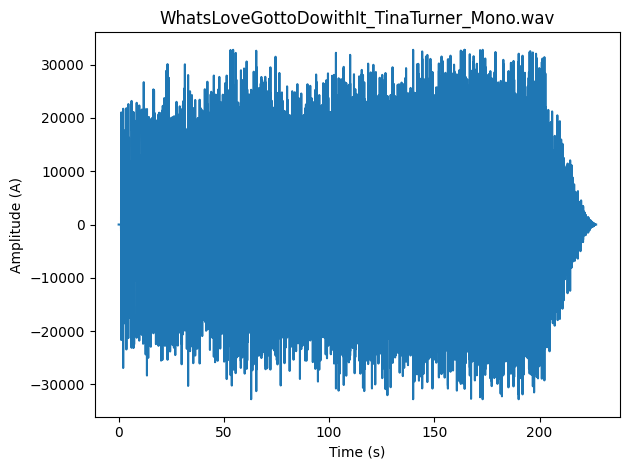

In [8]:
plot_signal(sample_rate, original_signal, file_name, doc_name = "original_signal")

We define a function to apply the dct to the audio file. In this function, we also have to save the signs matrix and the length of the window that goes through the audio file applying the dct:

In [9]:
def obtain_signs(mat):
    return np.where(mat >= 0, 1, -1)

In [10]:
def obtain_freq_array(signal, sample_rate = 48000, sample_anchor = 0.02, output_dir_name = "OUTPUT", signal_name = "ORIGINAL", mat_signs_filename = "mat_signs", segment_length_filename = "segment_length"): #, sample_rate_filename = "sample_rate.txt"):
    
    # Pre-process the signal by normalizing it to [-1, 1] range
    signal = signal / (2.0 ** 15)

    # Define the segment length for the DCT
    segment_length = round(sample_anchor * sample_rate) # sample_anchor: 20 ms
    
    # Save the segment_length 
    write_txt(output_dir_name, signal_name, segment_length_filename, segment_length)
    
    # Calculate the number of segments needed to cover the entire signal
    num_segments = len(signal) // segment_length

    # Apply DCT to each segment of the signal using a sliding window approach
    dct_segments = np.array([sp.dct(signal[i:i+segment_length], type=2) for i in range(0, len(signal)-segment_length, segment_length)])

    # Obtain the signs of the matrix
    mat_signs = obtain_signs(dct_segments)
    
    # Save the NumPy array to a file
    write_npy(output_dir_name, signal_name, mat_signs_filename, mat_signs)

    # Convert the DCT coefficients to a 2D frequency domain image
    freq_array = np.abs(dct_segments)
    
    # Apply logarithmic scaling to the magnitude values for visualization purposes
    freq_array = np.log(freq_array + 1)
    
    return freq_array, mat_signs, segment_length

In [11]:
def plot_freq_array(freq_array, doc_name = "doc"):
    print("The image below has a dimension of: ", freq_array.T.shape)

    # Display the frequency domain image
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.imshow(freq_array.T, aspect='auto', origin='lower')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (segment index)')
    
    fig.tight_layout()
    fig.savefig(doc_name + ".pdf", format='pdf')
    
    fig.show()

The image below has a dimension of:  (720, 15123)


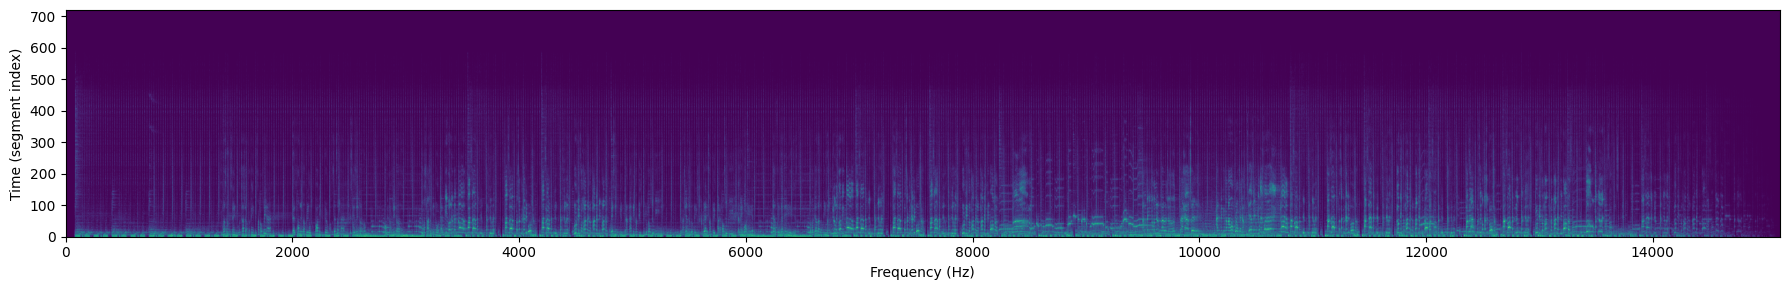

In [12]:
signal = original_signal.copy()
freq_array, mat_signs, segment_length = obtain_freq_array(signal, sample_anchor = 0.015, signal_name = "ORIGINAL")
plot_freq_array(freq_array, doc_name = "original_freq_domain")

## Freq ARRAY TO AUDIO

In [13]:
def obtain_dct_segments(freq_array, mat_signs):
    return (np.exp(freq_array) - 1) * mat_signs

In [14]:
def write_reconstructed_signal(freq_array, mat_signs, segment_length, sample_rate, output_dir_name = "OUTPUT", file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE"):
    # Inverse the process to reconstruct the original signal
    reconstructed_signal = np.zeros(len(signal))

    dct_segments = obtain_dct_segments(freq_array, mat_signs)

    for i, segment in enumerate(dct_segments):
        segment_signal = sp.idct(segment, type=2, norm='ortho')
        reconstructed_signal[i * segment_length : i * segment_length + segment_length] += segment_signal

    # Normalize the reconstructed signal to [-1, 1] range
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))

    # Scale the signal back to the original 16-bit range
    reconstructed_signal = np.int16(reconstructed_signal * (2**15))
    
    # Write the reconstructed signal to a new .wav file
    write_wav(file_name, sr = sample_rate, signal = reconstructed_signal, output_dir_name = output_dir_name)
    
    #return reconstructed_signal

In [15]:
write_reconstructed_signal(freq_array, mat_signs, segment_length, sample_rate, file_name = "RECONSTRUCTED_FROM_ORIGINAL_ARRAY")

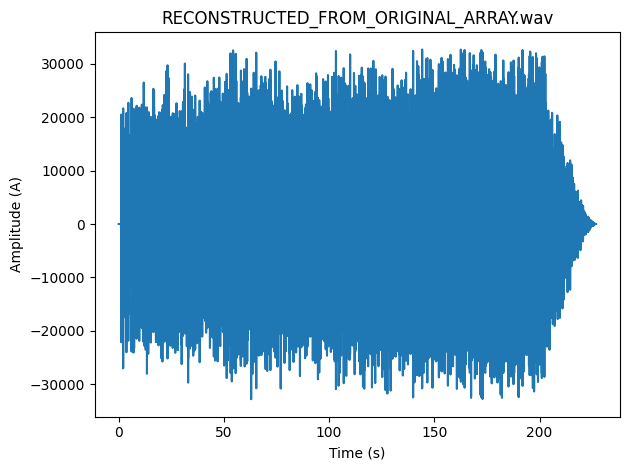

In [16]:
sample_rate, reconstructed_signal = read_wav(file_name = "RECONSTRUCTED_FROM_ORIGINAL_ARRAY", dir_name_input = "OUTPUT")
plot_signal(sample_rate, reconstructed_signal, "RECONSTRUCTED_FROM_ORIGINAL_ARRAY", file_suffix = "wav", doc_name="reconstructed_from_array")

## Comparation

Here we can see the difference between the original signal and the reconstructed one:

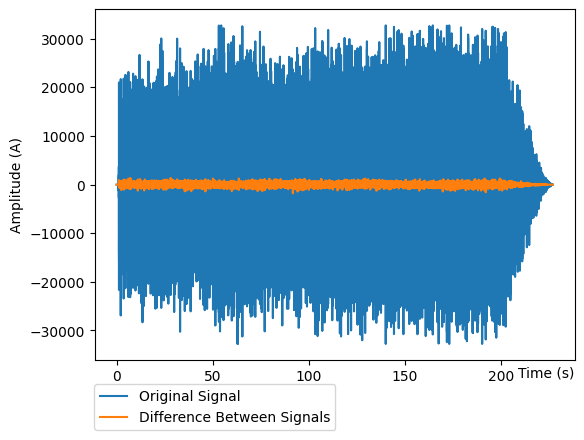

In [17]:
time = np.arange(len(original_signal)) / float(sample_rate)

fig, ax = plt.subplots()
ax.plot(time, original_signal, label="Original Signal")
ax.plot(time, original_signal - reconstructed_signal, label="Difference Between Signals")


ax.legend(loc='lower center', bbox_to_anchor=(0.25, -0.22))
ax.annotate('Time (s)', xy=(1, -0.05), xycoords='axes fraction', ha='right')
ax.set_ylabel("Amplitude (A)")

fig.subplots_adjust(bottom=0.15) 
fig.subplots_adjust(left=0.15) 

# We can save the figure if wanted
# plt.savefig("comparation_1.pdf", format='pdf')

plt.show()

In [18]:
def plot_diff(reconstructed_s, original_s = original_signal, time_line = time):
    plt.plot(time_line, original_s, label = "Original Signal")
    plt.plot(time_line, original_s - reconstructed_s, label = "Difference with reconstructed signal")
    plt.title("Signals Comparation")
    plt.ylabel("Amplitude (A)")
    plt.legend(loc='lower center', bbox_to_anchor=(0.25, -0.22))
    plt.annotate('Time (s)', xy=(1, -0.05), xycoords='axes fraction', ha='right')
    plt.show()

## Correlation and Squared Error

The correlation is the measurement we are going to use to quantify how good the reconstruction was: 

In [19]:
def correlation_normalized(signal_1, signal_2):
    signal_1_f = signal_1.astype('float64')
    signal_2_f = signal_2.astype('float64')
    
    x_gpu = cp.asarray(signal_1_f)
    y_gpu = cp.asarray(signal_2_f)
    
    corr_gpu = cp.correlate(x_gpu, y_gpu, mode='valid')
    corr_np = cp.asnumpy(corr_gpu)
    
    return corr_np/np.sqrt(np.sum(np.square(signal_1_f)) * np.sum(np.square(signal_2_f)))

<br>If the correlation is 1 then, good news! the signals are exactly the same, if the correlation is -1, then, the signals are exactly opposite to each other: 
<br>
<br>

In [20]:
corr_norm = correlation_normalized(original_signal, reconstructed_signal)
corr_norm

array([0.99906134])

<br>
We can also use the squared error to try to determine how much information we lose in the process. This measurement does not give us much information, unless we are comparing different signal differences. This way, if we are using a filter on the reconstructed signal to try to improve it, we can see how much it has improved by comparing its squared error against the unfiltered signal.
<br>
<br>

In [21]:
def se_signals(signal_1, signal_2):
    return (np.sum(np.square(signal_1.astype('float64') - signal_2.astype('float64'))))

In [22]:
# SE = Square Error (This metric doesn't give info at all: With big scales is difficult to understand the meaning)
se = se_signals(original_signal, reconstructed_signal)
se

553081156485.0

## Analyzing different frequency domains

We can filter the reconstructed signal, applying bandpass filters to see in which frequencies it loses more information:

In [23]:
def obtain_filters(sample_rate, freqs, N = 4):
    low_freq, high_freq = freqs
    nyquist_freq = 0.5 * sample_rate 

    #Cutoff frequencies bellow low_freq
    low_cutoff_freq = low_freq / nyquist_freq

    #Cutoff frequencies over high_freq
    high_cutoff_freq = high_freq / nyquist_freq

    b, a = s.butter(N, [low_cutoff_freq, high_cutoff_freq], 'bandpass')
    return b, a

def filter_signal(b, a, signal):
    return s.filtfilt(b, a, signal).astype("int16")

In [24]:
# https://www.headphonesty.com/2020/02/audio-frequency-spectrum-explained/
AF = dict([('sub_bass',[16, 60]),('bass',[60,250]),('low_mids',[250,500]),('mids',[500, 2000]),('high_mids',[2000,4000]),('presence',[4000,6000]),('brillance',[6000,20000])]) #audible frequencies  

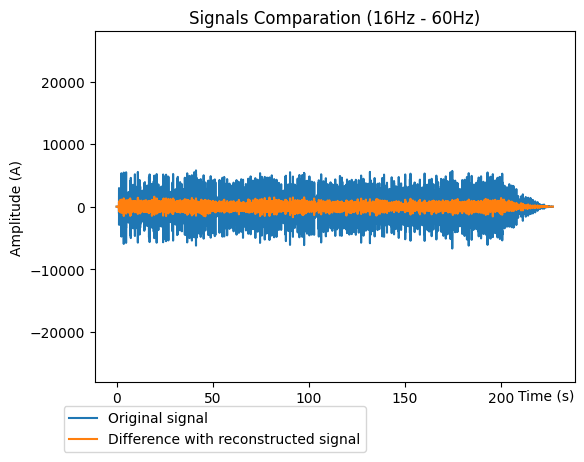

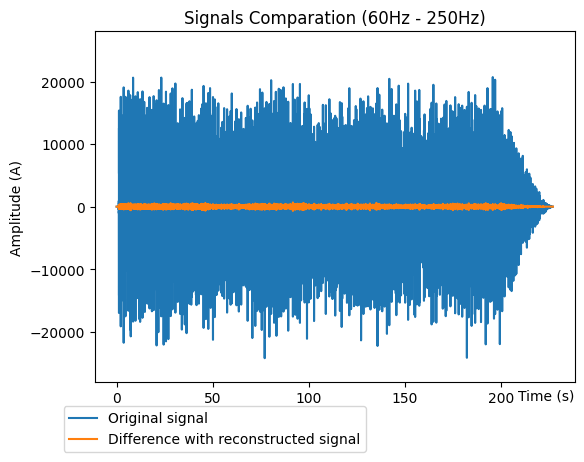

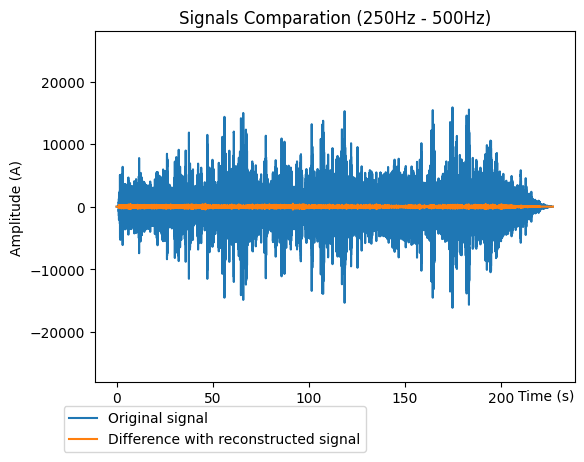

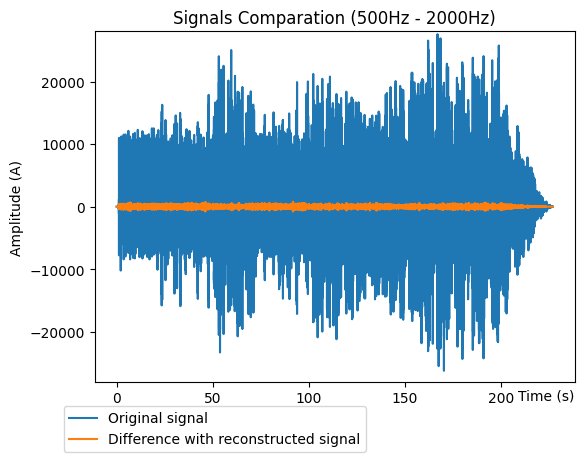

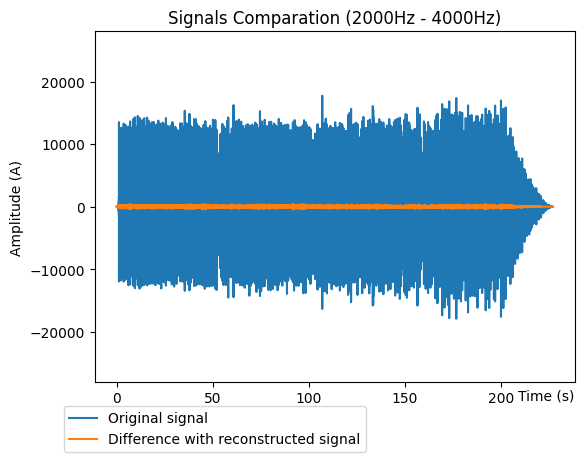

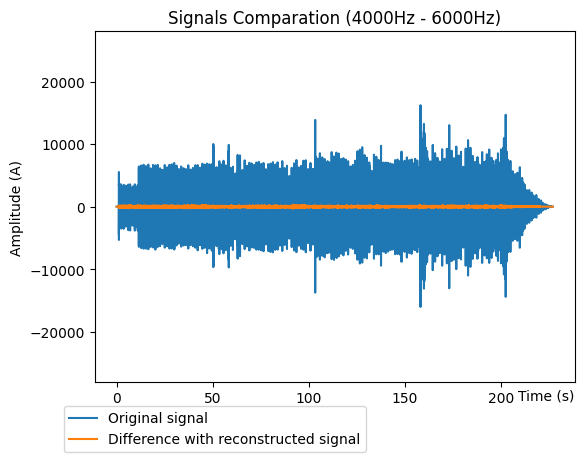

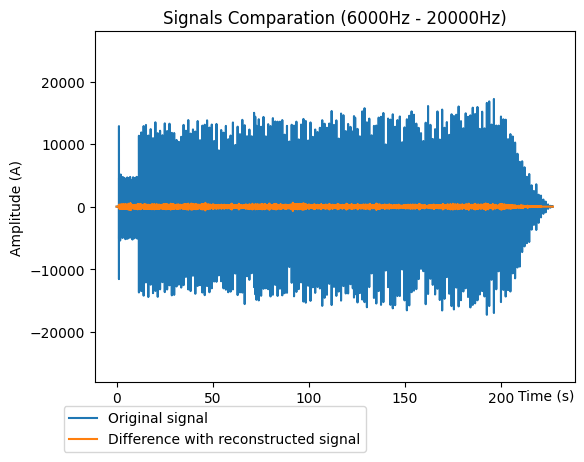

In [25]:
original_signals = []
reconstructed_signals = []

for freq in AF:
    
    b, a = obtain_filters(sample_rate, AF[freq], N = 3)
    
    filtered_original_signal_sfq = filter_signal(b, a, original_signal) # sfq = sub frequencies
    filtered_reconstructed_signal_sfq = filter_signal(b, a, reconstructed_signal) # sfq = sub frequencies
    
    original_signals.append(filtered_original_signal_sfq)
    reconstructed_signals.append(filtered_reconstructed_signal_sfq)
    
    fig, ax = plt.subplots(1, 1, sharex=True)
    ax.plot(time, filtered_original_signal_sfq, label = "Original signal")
    ax.plot(time, filtered_original_signal_sfq - filtered_reconstructed_signal_sfq, label = "Difference with reconstructed signal")
        
    ax.set_title(f'Signals Comparation ({AF[freq][0]}Hz - {AF[freq][1]}Hz)')
    ax.legend(loc='lower center', bbox_to_anchor=(0.25, -0.22))
    ax.annotate('Time (s)', xy=(1, -0.05), xycoords='axes fraction', ha='right')
    ax.set_ylabel("Amplitude (A)")
    ax.set_ylim(-28000, 28000)
    fig.subplots_adjust(bottom=0.15) 
    fig.subplots_adjust(left=0.15) 
    # We can save the figures if wanted
    # plt.savefig(f'comparation_{AF[freq][0]}Hz _ {AF[freq][1]}Hz.pdf', format='pdf')
    plt.show()

We could even save the sub bass frequencies or the brillance sounds to listen to them.

In [26]:
# write_wav("audio_signal_sub_bass", sample_rate, signal = reconstructed_signals[0])
# write_wav("audio_signal_brillance", sample_rate, signal = reconstructed_signals[-1])

In [27]:
correlations = []
for i in range(len(original_signals)):
    correlations.append(correlation_normalized(original_signals[i], reconstructed_signals[i]))

By sorting the frequency bands from the ones that have better correlation to worst, we can see where the information is being lost more:

In [28]:
correlations_list = [i[0] for i in correlations]
correlations_array = np.array(correlations_list)
correlations_array[np.isnan(correlations_array)] = 0

best_to_worst_freq = list(correlations_array.argsort()[::-1])
keys_list = np.array(list(AF.keys()))
print("Frequencies ordered from less losse to more losse depending on their correlation:\n")
for i in range (len(best_to_worst_freq)):
    print(keys_list[best_to_worst_freq[i]], ": ", round(correlations_array[best_to_worst_freq[i]], 7))

Frequencies ordered from less losse to more losse depending on their correlation:

mids :  0.9999627
presence :  0.9999624
high_mids :  0.9999372
brillance :  0.9998939
low_mids :  0.9998269
bass :  0.9997898
sub_bass :  0.985928


<br>
We can even save just a few groups of frequencies ommiting the last ones that have worse correlation:

In [29]:
# Select the first and third arrays
original_signals_ordered = [original_signals[i] for i in best_to_worst_freq]
reconstructed_signals_ordered = [reconstructed_signals[i] for i in best_to_worst_freq]

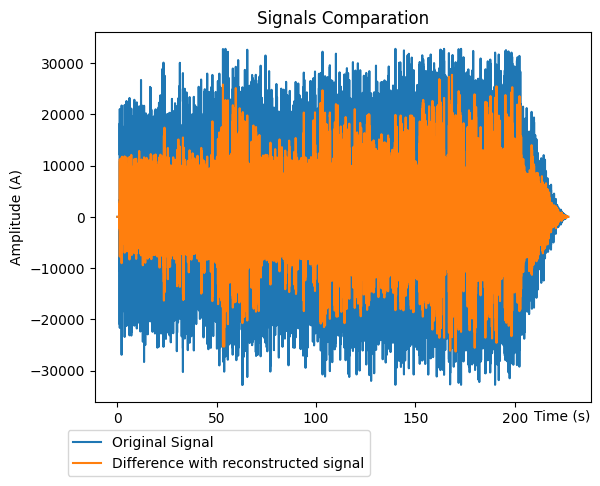

In [30]:
# The Original signal AND The Reconstruced signal simplified (Without Bass and Sub Bass frequencies)
original_simplified = None
reconstructed_simplified = None

for i in (correlations_array.argsort()[::-1][:5]):
    if original_simplified is None:
        original_simplified = original_signals_ordered[i]
        reconstructed_simplified = reconstructed_signals_ordered[i]
    else:
        original_simplified += original_signals_ordered[i]
        reconstructed_simplified += reconstructed_signals_ordered[i]

plot_diff(reconstructed_simplified)

And their correlation is:

In [32]:
corr_norm_2_2 = correlation_normalized(original_signal, reconstructed_simplified)

We can save the signal simplified:

In [33]:
write_wav("reconstruction_simplified", sample_rate, reconstructed_simplified)

## Filtering time domain signals between 20Hz - 20KHz (Humans range)

Since human perception is only capable of hearing frequencies between 20 Hz and 20 KHz, we can try applying a bandpass filter within this range. By this way, maybe the correlation between the original signal and the reconstructed one improves because we are avoiding some noise that could have been created during the DCT.

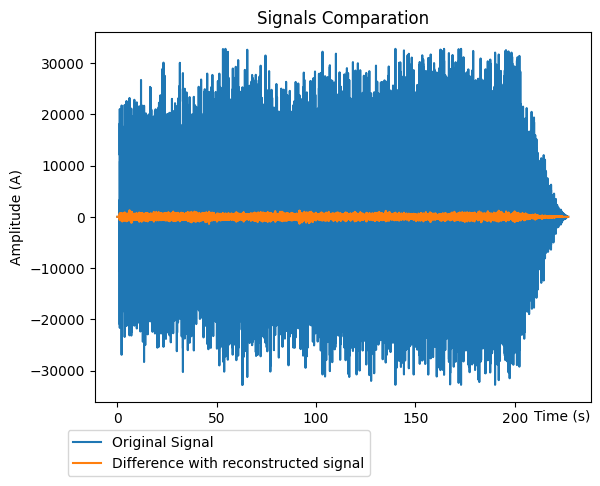

In [34]:
b, a = obtain_filters(sample_rate, [20, 20000])

filtered_original_signal = filter_signal(b, a, original_signal)
filtered_reconstructed_signal = filter_signal(b, a, reconstructed_signal)

plot_diff(filtered_reconstructed_signal)

In [36]:
corr_norm_3_2 = correlation_normalized(original_signal, filtered_reconstructed_signal)

If the squared error of the filtered reconstructed signal is less than the squared error of the unfiltered reconstructed signal, then the bandpass filter is useful:

In [37]:
SE_original_vs_reconstructed = se_signals(original_signal, reconstructed_signal)
SE_original_vs_reconstructed_filtered = se_signals(original_signal, filtered_reconstructed_signal)

SE_original_vs_reconstructed > SE_original_vs_reconstructed_filtered

True

So, this are our results:

In [38]:
# Create a list of tuples containing the table data
data = [
    ("\noriginal signal & reconstruction", "\033[1m{}\033[0m".format(corr_norm[0])),
    ("\noriginal signal & reconstruction (ommiting B & SB)", corr_norm_2_2[0]),
    ("\noriginal signal & reconstruction (20Hz-20KHz)", "\033[1m{}\033[0m".format(corr_norm_3_2[0]))
]

# Print the table headers
print("{:<80} {:<10}".format("Case", "Correlation"))
print("-" * 100)

# Print the table data
for row in data:
    print("{:<80} {:<10}".format(*row))

Case                                                                             Correlation
----------------------------------------------------------------------------------------------------

original signal & reconstruction                                                0.9990613371535584

original signal & reconstruction (ommiting B & SB)                              0.799027630910366

original signal & reconstruction (20Hz-20KHz)                                   0.9993243820589331


## Save freq array as image

Let's conclude the whole process to transform audio signals to image:

In [39]:
def save_max_min(freq_image, output_dir_name = "OUTPUT", signal_name = "ORIGINAL", max_filename = "max", min_filename = "min"):    
    write_txt(output_dir_name, signal_name, max_filename, freq_image.max(), data_type='%1.18f')
    write_txt(output_dir_name, signal_name, min_filename, freq_image.min(), data_type='%1.18f')
    
def read_max_min(dir_name_input, signal_name = "ORIGINAL", max_filename = "max", min_filename = "min"):
    
    max_filename = signal_name + "_" + max_filename + ".txt"
    min_filename = signal_name + "_" + min_filename + ".txt"
    
    file_location_max = join(dir_name_input, max_filename)
    file_location_min = join(dir_name_input, min_filename)
    
    freq_max = np.loadtxt(file_location_max, dtype=np.float64)
    freq_min = np.loadtxt(file_location_min, dtype=np.float64)
    return freq_max, freq_min

In [40]:
def save_array_as_image(arr_normalized, output_dir_name = "OUTPUT", signal_name = "ORIGINAL", img_filename = "image", img_suffix = "png"):#, frac_filename = "floating_part", frac_suffix = "npy"):
    
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)

    frac_part, int_part = np.modf(arr_normalized * 255)
    img = Image.fromarray(int_part.astype(np.uint8))
    
    img_filename = signal_name + "_" + img_filename + "." + img_suffix
    filename_output = os.path.join(output_path, img_filename)
#     frac_filename = signal_name + "_" + frac_filename + "." + "frac_suffix"
    
    img.save(filename_output)
#     np.save(frac_filename, frac_part)
    
def read_image(dir_name_input, signal_name = "ORIGINAL", img_filename = "image", img_suffix = "png"):# ,frac_filename = "floating_part.npy"):
    img_filename = signal_name + "_" + img_filename + "." + img_suffix
    #frac_filename = signal_name + "_" + frac_filename
    
    file_location_img = join(dir_name_input, img_filename)
    #file_location_frac = join(dir_name_input, frac_filename)
    
    return np.asarray(imageio.imread(file_location_img)).astype("float64")#, np.load(file_location_frac)

In [41]:
# We save the max and min values from the frequency array
save_max_min(freq_array, signal_name = "ORIGINAL")

# normalize the array to the range [0,1]
arr_normalized = (freq_array.T - freq_array.T.min()) / (freq_array.T.max() - freq_array.T.min())
save_array_as_image(arr_normalized, signal_name = "ORIGINAL")

# IMAGE TO AUDIO:

## Read Image

The image below has a dimension of:  (720, 15123)


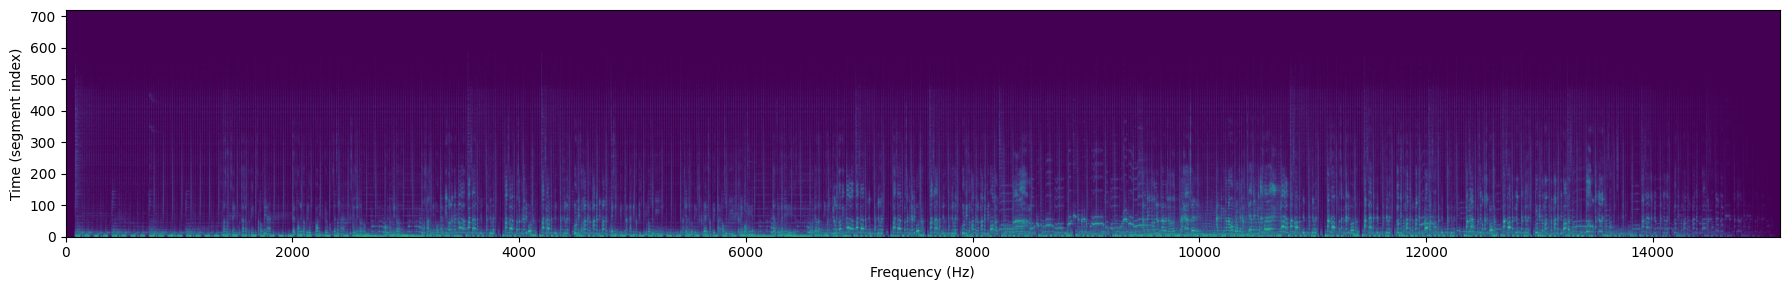

In [42]:
# read the image as a numpy array
# read_image(dir_name_input, signal_name = "ORIGINAL", img_filename = "image", img_suffix = "png")
img_float64 = read_image(dir_name_input = "OUTPUT", signal_name = "ORIGINAL")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT", signal_name = "ORIGINAL")

# return the original values
img_reconstructed = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed.T)

In [43]:
#MSE
mse_1 = se_signals(img_reconstructed, freq_array.T)/(img_reconstructed.shape[0]*img_reconstructed.shape[1])
print(mse_1)

0.00012797361752123817


# Audio Reconstruction from image .png

In [44]:
# img_reconstructed
mat_signs = np.load(join("OUTPUT", "ORIGINAL_mat_signs.npy"))

#sample_rate = 48000, sample_anchor = 0.02
segment_length = np.loadtxt(join("OUTPUT", "ORIGINAL_segment_length.txt"), dtype=int)

In [45]:
reconstructed_signal_2 = write_reconstructed_signal(img_reconstructed.T, mat_signs, segment_length, sample_rate, file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE")

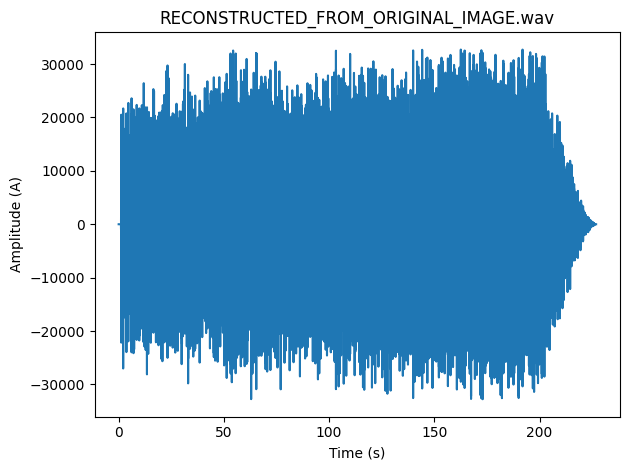

In [46]:
sample_rate_2, reconstructed_signal_2 = read_wav(file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE", dir_name_input = "OUTPUT")
plot_signal(sample_rate_2, reconstructed_signal_2, file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE", file_suffix = "wav", doc_name="reconstructed_from_png")

In [47]:
corr_from_image = correlation_normalized(original_signal, reconstructed_signal_2)
corr_from_image

array([0.99903614])

## Bandpass 20 Hz - 20 KHz

Again we apply a bandpass filter to try to avoid some noise from the process:

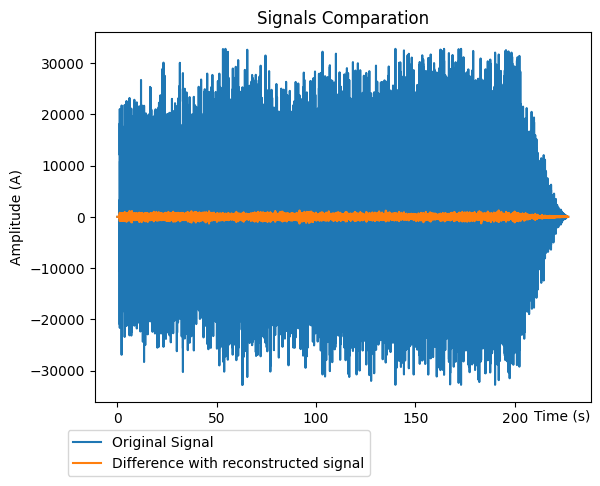

In [48]:
b, a = obtain_filters(sample_rate_2, [20, 20000])
filtered_reconstructed_signal_2 = filter_signal(b, a, reconstructed_signal_2)

plot_diff(filtered_reconstructed_signal_2)

In [49]:
corr_from_image_2 = correlation_normalized(original_signal, filtered_reconstructed_signal_2)

In [50]:
# Create a list of tuples containing the table data
data = [
    ("\noriginal signal & reconstruction", "\033[1m{}\033[0m".format(corr_norm[0])),
    ("\noriginal signal & reconstruction (20Hz-20KHz)", "\033[1m{}\033[0m".format(corr_norm_3_2[0])),
    ("\noriginal signal & reconstruction from image", str(corr_from_image)),
    ("\noriginal signal & reconstruction from image (20Hz-20KHz)", "\033[1m{}\033[0m".format(corr_from_image_2))
]

# Print the table headers
print("{:<80} {:<10}".format("Case", "Correlation"))
print("-" * 100)

# Print the table data
for row in data:
    print("{:<80} {:<10}".format(*row))

Case                                                                             Correlation
----------------------------------------------------------------------------------------------------

original signal & reconstruction                                                0.9990613371535584

original signal & reconstruction (20Hz-20KHz)                                   0.9993243820589331

original signal & reconstruction from image                                     [0.99903614]

original signal & reconstruction from image (20Hz-20KHz)                        [0.99929945]


# Saving wav filtered

In [51]:
# # Write the reconstructed signal to a new .wav file
write_wav("RECONSTRUCTED_FROM_ORIGINAL_IMAGE_AND_FILTERED", sample_rate_2, filtered_reconstructed_signal_2)

<br>
We can check if we have saved the audio file correctly simply by comparing the correlation between this audio and the one which we used to create it:

In [52]:
sample_rate_3, filtered_reconstructed_signal_3 = read_wav(file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE_AND_FILTERED", dir_name_input = "OUTPUT")

If the result is "1" we did it correctly:

In [53]:
ncorr_3 = correlation_normalized(filtered_reconstructed_signal_2.astype("int16"), filtered_reconstructed_signal_3)
ncorr_3

array([1.])